# Recitation 0: Pytorch Basics Overview

**Note: please make a COPY of the notebook if you'll be making any changes or running any cells**

We'll be using pytorch for several coding assignments in this class. This tutorial covers:
* Setting up a training and evaluation loop
* Defining a data iterator, nn.Module, loss and evaluation functions, etc.
* Implementing a forward and a backward pass in custom torch autograd functions

We'll be using sentiment classification of IMDB reviews as our running example.

## Tensors

PyTorch defines and uses Tensors for all of it's operations, which are very similar to numpy ndarrays. Like ndarrays, PyTorch tensors are also multidimensional arrays of data with a specified datatype. But pytorch tensors and operations defined in PyTorch over them let you easily transition to using GPUs or TPUs to speed up computation. And most importantly, PyTorch has autograd, which automatically constructs a computational graph making it easy to compute gradients for each tensor since most supported tensor operations come with gradient functions defined.

#### Creating Tensors

In [ ]:
import torch
import numpy as np

# You can make a tensor directly from data
data = [[1., 2.], [3., 4.]]
x_data = torch.tensor(data)
print(x_data)
print(x_data.dtype)
print()

# Call tensor.numpy() to get a numpy array.
# (Note that this only works on detached cpu tensors, should be clear after autograd is explained)
print(x_data.numpy())

tensor([[1., 2.],
        [3., 4.]])
torch.float32

[[1. 2.]
 [3. 4.]]


In [ ]:
# You can also make a tensor from a numpy array
data = [[1., 2.], [3., 4.]]
np_data = np.asarray(data, dtype=np.float32)
x_data = torch.from_numpy(np_data)

print(x_data)
print(x_data.dtype)

# Note:
# While this method to construct arrays is very common,
# the np array and tensor share the same underlying memory.
# So, changing the ndarray would change the tensor and vice-versa.
np_data[0][0] = -1
print(x_data)

tensor([[1., 2.],
        [3., 4.]])
torch.float32
tensor([[-1.,  2.],
        [ 3.,  4.]])


In [ ]:
# A few other useful ways to initialize tensors with constant or random values

# Create an array of all ones:
print("torch.ones((2, 2, 2)) creates a (2, 2, 2) tensor of ones:\n", torch.ones((2, 2, 2)))
print()

# Create an array of all zeros:
print("torch.zeros((2, 2, 2)) creates a (2, 2, 2) tensor of zeros:\n", torch.zeros((2, 2, 2)))
print()

# Create an array of random floats ~ Unif[0, 1):
print("torch.rand((2, 2, 2)) creates a (2, 2, 2) tensor from the uniform distribution :\n", torch.rand((2, 2, 2)))
print()

torch.ones((2, 2, 2)) creates a (2, 2, 2) tensor of ones:
 tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])

torch.zeros((2, 2, 2)) creates a (2, 2, 2) tensor of zeros:
 tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

torch.rand((2, 2, 2)) creates a (2, 2, 2) tensor from the uniform distribution :
 tensor([[[0.5521, 0.7621],
         [0.6521, 0.1582]],

        [[0.6600, 0.0167],
         [0.8219, 0.1858]]])



### Tensor operations

In [ ]:
# clone() creates a copy of a tensor
x = torch.rand((2,))
x_clone = x.clone()

print(x, x_clone)
x_clone[0] = 0.

print(x, x_clone)

tensor([0.0671, 0.0889]) tensor([0.0671, 0.0889])
tensor([0.0671, 0.0889]) tensor([0.0000, 0.0889])


In [ ]:
# Standard numpy style slicing and indexing works, as well as standard arithmetic operations
x = torch.rand((4, 4))
print("x:", x)

print("Slice:\n", x[:, 1: 3])

print("\nElement-wise arithmetic ops:")

x = torch.ones((2, 2))
y = torch.ones((2, 2))
print("x:", x)
print("y:", y)
print("x + y:\n", x + y)
print("x - y:\n", x - y)
print("x * y:\n", x * y)
print("x / y:\n", x / y)

print("Matrix multiplication:")
print("x @ y", x @ y)


x: tensor([[0.2879, 0.0337, 0.3370, 0.2031],
        [0.2607, 0.0806, 0.2770, 0.1243],
        [0.7986, 0.6822, 0.8398, 0.2266],
        [0.6629, 0.1453, 0.2441, 0.4694]])
Slice:
 tensor([[0.0337, 0.3370],
        [0.0806, 0.2770],
        [0.6822, 0.8398],
        [0.1453, 0.2441]])

Element-wise arithmetic ops:
x: tensor([[1., 1.],
        [1., 1.]])
y: tensor([[1., 1.],
        [1., 1.]])
x + y:
 tensor([[2., 2.],
        [2., 2.]])
x - y:
 tensor([[0., 0.],
        [0., 0.]])
x * y:
 tensor([[1., 1.],
        [1., 1.]])
x / y:
 tensor([[1., 1.],
        [1., 1.]])
Matrix multiplication:
x @ y tensor([[2., 2.],
        [2., 2.]])


In [ ]:
# Use torch.cat to concatenate two tensors along an existing dimension

x = torch.zeros((2, 2))
y = torch.ones((2, 3))

print("torch.cat((x, y), dim=1):\n", torch.cat((x, y), dim=1))
print()

# Use torch.stack to stack tensors of equal dimension along a new axis

a = torch.zeros((2, 2))
b = torch.ones((2, 2))

stacked = torch.stack((a, b), dim=0)
print("stacked tensor:\n", stacked)
print("stacked tensor shape:\n", stacked.shape)

torch.cat((x, y), dim=1):
 tensor([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]])

stacked tensor:
 tensor([[[0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.]]])
stacked tensor shape:
 torch.Size([2, 2, 2])


Some other useful operations to read into from the pytorch documentation
- view (reshapes array, but only works on contiguous arrays: https://discuss.pytorch.org/t/difference-between-view-reshape-and-permute/54157)
- reshape
- transpose
- squeeze
- unsqueeze
- sum
- mean


##Building Computation Graphs with Tensors

In [ ]:
# Automatic differentiation is enabled on most pytorch operations, which get tracked through the computation graph
x = torch.rand((2, 2), requires_grad=True)
x

tensor([[0.1891, 0.2771],
        [0.3650, 0.2750]], requires_grad=True)

In [ ]:
# For example, the slice "operation" has it's own backward gradient function defined
x[1:2]

tensor([[0.3650, 0.2750]], grad_fn=<SliceBackward0>)

In [ ]:
# Or the sum operation
x.sum()

tensor(1.1062, grad_fn=<SumBackward0>)

In [ ]:
# We can call a backward() pass on any pytorch scalar attached to a computation graph
x = torch.rand((2, 2), requires_grad=True)
print("x: ", x)

y = x * 2
print("y: ", y)

z = y[0]
print("z: ", z)

loss = z.sum()
print(loss)

x:  tensor([[0.8017, 0.8857],
        [0.6874, 0.6279]], requires_grad=True)
y:  tensor([[1.6035, 1.7715],
        [1.3747, 1.2557]], grad_fn=<MulBackward0>)
z:  tensor([1.6035, 1.7715], grad_fn=<SelectBackward0>)
tensor(3.3749, grad_fn=<SumBackward0>)


In [ ]:
# Leaf variables in the computation graph (like x here) have a gradient attached
#  which is by default None
print(x.grad)

None


In [ ]:
# A .backward() call runs a backward pass through the computation graph and populates the .grad for leaf variables
loss.backward()

print(x.grad)

tensor([[2., 2.],
        [0., 0.]])


In [ ]:
# Non leaf variables do not have their .grad populated after a backward pass
#  If interested, look into "retain_graph" here: https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
print(y.grad)

None


<ipython-input-12-d3c80e6c2114>:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(y.grad)


## Datasets & DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

#### Loading a Dataset

Here is an example of how to load the [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples.
Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 119593586.54it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8714267.39it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 67550360.04it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19919074.72it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



#### Iterating and Visualizing the Dataset

We can index ``Datasets`` manually like a list: ``training_data[index]``.
We use ``matplotlib`` to visualize some samples in our training data.

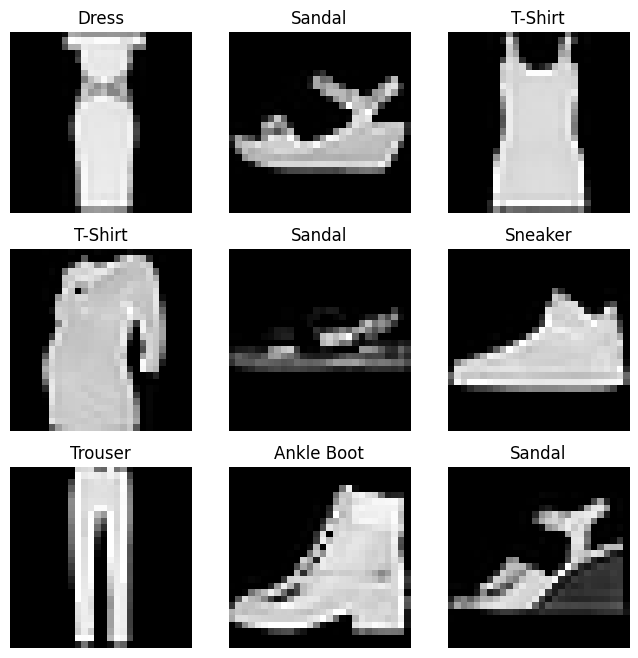

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
Take a look at this implementation; the FashionMNIST images are stored
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In the next sections, we'll break down what's happening in each of these functions.

##### ``__init__``

The __init__ function is run once when instantiating the Dataset object. We initialize
the directory containing the images, the annotations file, and both transforms (covered
in more detail in the next section).

##### ``__len__``

The __len__ function returns the number of samples in our dataset.

##### ``__getitem__``

The __getitem__ function loads and returns a sample from the dataset at the given index ``idx``.
Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the
corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the
tensor image and corresponding label in a tuple.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### Preparing your data for training with DataLoaders
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### Iterate through the DataLoader

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over
the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


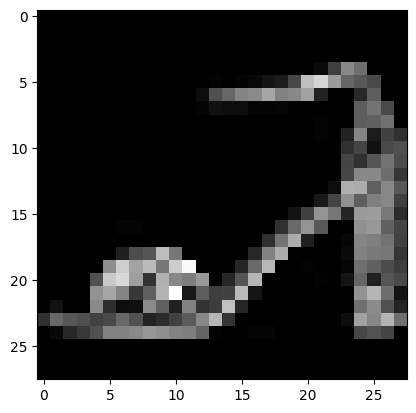

Label: 5


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Neural Network *Construction*

Neural networks are usually defined by classes that inherit from the **nn.Module** class.

For each network, we define a **`forward`** function that is run in the forward pass through the network.

In Pytorch, **backpropagation** is done through automatic differentiation. It traverses backwards from the output, collecting gradients (derivatives of the error with respect to the parameters of the functions), and optimizes using gradient descent (or whichever optimization algorithm is chosen). Note that when you instantiate parameters that need to be updated, you should make sure that `requires_grad` is set to `True`. This signals to autograd that every operation on it should be tracked.

Below are several neural net modules we can use in our final architecture:

In [ ]:
from itertools import tee
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np


# Basic multi-layer perceptron class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear_layer = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.output_layer(self.activation(self.linear_layer(x)))

## Advanced: Under the hood of a Linear layer

Sometimes, we may want to add operations to `autograd` that is not already included in pytorch. To help you understand how we might do this, let's study how nn.Linear is implemented.

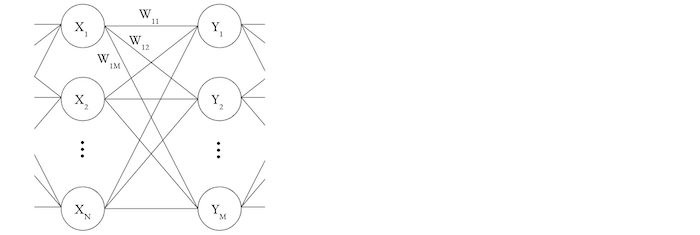

`Function`'s are what `autograd` uses to compute the results and gradients, and encode the operation history. When defining a new `Function`, we must define static methods `forward()` which performs the operation and `backward()` which computes the gradient formulas with respect to the arguments to the forward function.

**Forward pass**: For a linear layer, given an input $X \in \mathbb{R}^{N \times D}$ and weights $W \in \mathbb{R}^{D \times M}$, the forward pass computes the output $Y = XW$, where $Y \in \mathbb{R}^{N \times M}$. Note that a bias can be represented by adding an additional dimension to $X$ containing 1's, and a corresponding additional dimension to the weights.

<!-- For a linear layer, given an input $x \in \mathbb{R}^{D \times 1}$, weights $W \in \mathbb{R}^{D \times M}$, and bias $b \in \mathbb{R}^{M \times 1}$, the forward pass computes the output $y = W^Tx + b$, where $y \in \mathbb{R}^{M \times 1}$. -->

**Backward pass**: During the backward pass, we assume that the upstream gradient $\frac{\partial L}{\partial Y}$ has already been computed. Given this upstream gradient, we aim to calculate $\frac{\partial L}{\partial X}$ and $\frac{\partial L}{\partial W}$. Applying the chain rule, we get:

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y}W^{T}$$

$$\frac{\partial L}{\partial W} = X^{T}\frac{\partial L}{\partial Y}$$

These are the gradients returned by the `backward()` function (note that we can compute the gradient with respect to the bias by plugging in a vector of 1's for X in the last expression above).


In [ ]:
# Inherit from Function
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)  # save to help compute grad
        output = input.mm(weight.t())               # multiply w/ weight matrix
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional.
        # Returning gradients for inputs that don't require it is not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

Given the `LinearFunction`, we can now define the `Linear` `nn.Module` that uses it.

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(Linear, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        self.weight.data.uniform_(-0.1, 0.1)
        if self.bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

Composing linear layers together, we can form an MLP.

In [ ]:
# Multi-layer perceptron class using custom Linear module
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear_layer = Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.output_layer = Linear(hidden_size, output_size)

    def forward(self, x):
        return self.output_layer(self.activation(self.linear_layer(x)))

## Evaluation metric

Since we have binary labels, we can compute accuracy as our metric of interest.

In [ ]:
# Define evaluation metric
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    rounded_preds = torch.argmax(nn.functional.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

## Advanced: Custom loss function

Sometimes, the loss function you want to use may not already be implemented in Pytorch. To implement such as loss based on a function that does not already exist in pytorch, you can first implement a `Function` and then define a `nn.Module` loss based on that Function. Here's an example implementation for the binary cross-entropy loss function.

**Forward pass:** Given a set of $N$ datapoints, with corresponding binary class indicators, $\{y_i\}_{i=1}^N$, where each $y_i \in \{0,1\}$, and a set of predictions $p_i = P(y_i=1)$ that represent the probability that the $i^\text{th}$ sample belongs to class $y=1$, the binary cross entropy is given by,

$$ L = \frac{1}{N} \sum_{i=1}^N \left( y_i\log(p_i) + (1-y_i) \log (1-p_i) \right)$$

**Backward pass:** We would like to compute the gradients of the loss with respect to the inputs to the loss functions. Generally, there are no upstream gradients for the loss, but in keeping with convention, these are passed to the `backward` method as `grad_output`. The gradient of the loss with respect to the $p_i$ (`input`) is given by

$$ \frac{\partial L}{\partial p_i} = \frac{y_i - p_i}{p_i(1-p_i)} $$
The binary class indicators (`target`) are discrete variables, and the gradient of the loss with respect to these indicators is not defined. Therefore, we return a `None` object for this gradient.

In [ ]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, input, target):
        ctx.save_for_backward(input, target)      # save to help compute grad
        return -(target*torch.log(input)).sum(axis=1).mean()

    @staticmethod
    def backward(ctx, grad_output):
        input_y, target_y = ctx.saved_tensors
        grad_input = grad_target = None

        grad_input = grad_output * (-target_y/input_y)
        return grad_input, grad_target


In [ ]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()

    def forward(self, prediction, target):
        softmax_preds = nn.Softmax(dim=1)(prediction)
        return CrossEntropyFunction.apply(softmax_preds,target)

## Initiate the model

In [ ]:
INPUT_SIZE = 784
HIDDEN_SIZE = 200
OUTPUT_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)

## Weights and Biases Setups

In [ ]:
# Install wandb
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import wandb

# API Key is in your wandb settings
wandb.login(key="YOUR API KEY HERE")

# Initialize your run
run = wandb.init(
    name = "linear network", # Enter useful info to prevent confusions
    reinit = True,
    project = "10-423-623 Recitation 0", # Runs under the same project can be plotted together
)

# Save your network architecture as txt
network_architecture = open("network_architecture.txt", "w")
network_architecture.write(str(model))
network_architecture.close()

# Log this file into wandb (or any other files you want to save in a similar manner)
wandb.save('network_architecture.txt')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hhe2. Use `wandb login --relogin` to force relogin


['/content/wandb/run-20240119_210850-l5ioxxql/files/network_architecture.txt']

##Training the Classifier

Now, let's put everything together and train the classifier.

In [ ]:
# Procedures for training and evaluation

def train(model, dataloader, n_epochs, learning_rate):
    # Tells the model we are in training mode.
    # Only needed for certain layers (e.g. batchnorm, dropout)
    model.train()

    # You can pick from a variety of loss functions, or write your own.
    loss_fn = nn.CrossEntropyLoss()

    # Defining the optimizer here. Other options include Adam, etc.
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    best_acc = 0.0

    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        epoch_acc = 0.0

        num_batches = len(dataloader)

        for i, (feature, label) in enumerate(dataloader):
            # Clear the gradients from previous iteration.
            # (Forgetting this is a common mistake!)
            optimizer.zero_grad()

            # Move data to the corresponding device
            feature, label = feature.to(device), label.to(device)

            # Forward pass of the network. It will return the predictions.
            predictions = model(feature.view(-1, 784))

            # Calculate the loss of the predictions with respect to the actual labels.
            loss = loss_fn(predictions, label)
            acc = binary_accuracy(predictions, label)

            # This step is the backward pass.
            loss.backward()

            # This step is calling the optimizer to do autodiff.
            optimizer.step()

            # Adding the loss of current batch to the sum of loss of this epoch.
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        # Divide over batch (since we added every batch)
        epoch_loss /= num_batches
        epoch_acc /= num_batches

        print("Epoch {}: Loss: {}, Accuracy: {}".format(epoch,
                                                        epoch_loss,
                                                        epoch_acc))

        # Log the loss and accuracy in wandb as well
        wandb.log({"Loss": epoch_loss, "Accuracy": epoch_acc})

        # Update best checkpoint
        if epoch_acc >= best_acc:
            # Save checkpoint with information you want (torch)
            torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'acc': epoch_acc},
              './checkpoint.pth')
            # Backup the checkpoint on wandb as well
            wandb.save('checkpoint.pth')

def evaluate(model, dataloader):
    total_acc = 0
    model.eval()

    num_batches = len(dataloader)

    with torch.no_grad():
        for i, (feature, label) in enumerate(dataloader):
            feature, label = feature.to(device), label.to(device)
            predictions = model(feature.view(-1, 784))
            acc = binary_accuracy(predictions, label)
            total_acc += acc.item()

    return total_acc / num_batches

In [ ]:
train(model, train_dataloader, EPOCHS, LEARNING_RATE)
test_acc = evaluate(model, test_dataloader)
print('Test Set Accuracy {}'.format(test_acc))

# Finish your wandb run
run.finish()

Epoch 0: Loss: 1.684110640971137, Accuracy: 0.5880863539445629
Epoch 1: Loss: 1.0585289976871344, Accuracy: 0.712719882729211
Epoch 2: Loss: 0.8531051897672194, Accuracy: 0.7366904317697228
Epoch 3: Loss: 0.7556515449463431, Accuracy: 0.7508995202558635
Epoch 4: Loss: 0.6983635427156237, Accuracy: 0.7620435767590619
Epoch 5: Loss: 0.6597564252518388, Accuracy: 0.7712386727078892
Epoch 6: Loss: 0.6308771291457768, Accuracy: 0.7797174840085288
Epoch 7: Loss: 0.6076165934615552, Accuracy: 0.7868470149253731
Epoch 8: Loss: 0.5884040702761871, Accuracy: 0.7939598880597015
Epoch 9: Loss: 0.5723814216694598, Accuracy: 0.8002565298507462
Test Set Accuracy 0.7902070063694268


Accuracy,▁▅▆▆▇▇▇███
Loss,█▄▃▂▂▂▁▁▁▁
Accuracy,0.80026
Loss,0.57238
